In [10]:
torch.cuda.empty_cache()


In [1]:
import pandas as pd
import re

# Install necessary packages
!pip install transformers pandas torch nltk matplotlib numpy joblib

# Import the installed packages
import nltk

# Data visualization (optional, for visualizing data distributions)
import matplotlib.pyplot as plt

# Numpy (optional, for numerical operations)
import numpy as np

# String module (optional, for additional string operations)
import string

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import torch

# Custom list of Urdu stopwords
urdu_stopwords = set([
    'اور', 'کے', 'میں', 'سے', 'کو', 'پر', 'ہے', 'کی', 'کہ', 'یہ', 'جو', 'بھی', 'کا', 'نے', 'گا', 'کر',
    'ہیں', 'ایک', 'سب', 'تو', 'وہ', 'تم', 'جب', 'ہم', 'یا', 'نہیں', 'وہاں', 'تھا', 'تھی', 'تھے', 'اگر',
    'یہاں', 'ہوں', 'رہا', 'گئی', 'تھا', 'تھی', 'تھے'
])

# Load the dataset
data = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

data['Tweets'] = data['Tweets'].apply(remove_html_tags)

# Handle missing values and remove duplicates
data.dropna(subset=['Tweets'], inplace=True)
data.drop_duplicates(subset=['Tweets'], inplace=True)

# Normalize text
def normalize_text(text):
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    text = text.replace('ۀ', 'ہ').replace('ۂ', 'ہ').replace('ؤ', 'و').replace('ئ', 'ی')
    return text

data['Tweets'] = data['Tweets'].apply(normalize_text)

# Remove stop words using the custom list of Urdu stopwords
data['cleaned_text'] = data['Tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in urdu_stopwords]))

# Split the dataset into train and validation sets (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], test_size=0.2, random_state=42)

### BERT Training

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 2e-5

# Create DataLoader
train_dataset = TweetDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
val_dataset = TweetDataset(X_test.tolist(), y_test.tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_dataset)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_dataset)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()


  Using cached transformers-4.43.3-py3-none-any.whl (9.4 MB)
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached tokenizers-0.19.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Using cached regex-2024.7.24-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (775 kB)
  Using cached safetensors-0.4.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached huggingface_hub-0.24.3-py3-none-any.whl (417 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Epoch 1/4
----------
Train loss 0.6668465360026447 accuracy 0.5808295231874592
Val   loss 0.6109009090190133 accuracy 0.6446766819072501

Epoch 2/4
----------


KeyboardInterrupt: 

In [2]:
import pandas as pd
import re

# Install necessary packages
!pip install transformers pandas torch nltk matplotlib numpy joblib

# Import the installed packages
import nltk

# Data visualization (optional, for visualizing data distributions)
import matplotlib.pyplot as plt

# Numpy (optional, for numerical operations)
import numpy as np

# String module (optional, for additional string operations)
import string

  Using cached transformers-4.42.4-py3-none-any.whl (9.3 MB)
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached huggingface_hub-0.24.0-py3-none-any.whl (419 kB)
  Using cached tokenizers-0.19.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Using cached safetensors-0.4.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached regex-2024.5.15-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (774 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [3]:
import pandas as pd
import re
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np

# Custom list of Urdu stopwords
urdu_stopwords = set([
    'اور', 'کے', 'میں', 'سے', 'کو', 'پر', 'ہے', 'کی', 'کہ', 'یہ', 'جو', 'بھی', 'کا', 'نے', 'گا', 'کر',
    'ہیں', 'ایک', 'سب', 'تو', 'وہ', 'تم', 'جب', 'ہم', 'یا', 'نہیں', 'وہاں', 'تھا', 'تھی', 'تھے', 'اگر',
    'یہاں', 'ہوں', 'رہا', 'گئی', 'تھا', 'تھی', 'تھے'
])

# Load the dataset
data = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

data['Tweets'] = data['Tweets'].apply(remove_html_tags)

# Handle missing values and remove duplicates
data.dropna(subset=['Tweets'], inplace=True)
data.drop_duplicates(subset=['Tweets'], inplace=True)

# Normalize text
def normalize_text(text):
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    text = text.replace('ۀ', 'ہ').replace('ۂ', 'ہ').replace('ؤ', 'و').replace('ئ', 'ی')
    return text

data['Tweets'] = data['Tweets'].apply(normalize_text)

# Remove stop words using the custom list of Urdu stopwords
data['cleaned_text'] = data['Tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in urdu_stopwords]))

# Split the dataset into train and validation sets (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], test_size=0.2, random_state=42)

### BERT Training

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5

# Create DataLoader
train_dataset = TweetDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
val_dataset = TweetDataset(X_test.tolist(), y_test.tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    
    return accuracy, precision, recall, f1, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_dataset)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_precision, val_recall, val_f1, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_dataset)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc} precision {val_precision} recall {val_recall} f1 {val_f1}')
    print()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5
----------
Train loss 0.6504499426709766 accuracy 0.6041802743305029
Val   loss 0.5592489195987582 accuracy 0.7099934683213586 precision 0.7021276595744681 recall 0.7557251908396947 f1 0.7279411764705883

Epoch 2/5
----------
Train loss 0.5051030906855905 accuracy 0.756041802743305
Val   loss 0.4999412229905526 accuracy 0.744611365120836 precision 0.7277970011534025 recall 0.8027989821882952 f1 0.76346037507562

Epoch 3/5
----------
Train loss 0.3838357144563067 accuracy 0.8278902677988244
Val   loss 0.4958738316781819 accuracy 0.7491835401698237 precision 0.7451219512195122 recall 0.77735368956743 f1 0.7608966376089663

Epoch 4/5
----------
Train loss 0.24135892879091417 accuracy 0.9033311561071196
Val   loss 0.6419611346597472 accuracy 0.7537557152188112 precision 0.769433465085639 recall 0.7430025445292621 f1 0.7559870550161812

Epoch 5/5
----------
Train loss 0.13649148020805796 accuracy 0.9528086218158067
Val   loss 0.7932856796154132 accuracy 0.7498367080339647 precisio

In [4]:
# Save the model after training
model_save_path = "bert_model_final.bin"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to bert_model_final.bin


In [6]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Define the model architecture (based on what you know about the model)
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)

# Load the weights from the .bin file
weights_path = '/home/jovyan/sentiment/all_models/Bert_cased.bin'  # Update with the path to your .bin file
model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))

# Save the complete model (including config)
model_save_path = 'BERT_CASED'
model.save_pretrained(model_save_path)

# Also save the tokenizer (assuming it's the same as used in training)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
tokenizer.save_pretrained(model_save_path)


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

('BERT_CASED/tokenizer_config.json',
 'BERT_CASED/special_tokens_map.json',
 'BERT_CASED/vocab.txt',
 'BERT_CASED/added_tokens.json')

In [8]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re

# Function to remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# Function to normalize text
def normalize_text(text):
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    text = text.replace('ۀ', 'ہ').replace('ۂ', 'ہ').replace('ؤ', 'و').replace('ئ', 'ی')
    return text

# Custom Dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load the pre-trained model and tokenizer
model_path = '/home/jovyan/sentiment/BERT_CASED' # Update with the path to your model directory
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Device configuration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Load and preprocess the test dataset
test_data = pd.read_csv('/home/jovyan/sentiment/test_dataset.csv')  # Update with the path to your test dataset
test_data['Tweets'] = test_data['Tweets'].apply(remove_html_tags).apply(normalize_text)

# Define the test dataset and DataLoader
MAX_LEN = 128
BATCH_SIZE = 16
test_dataset = TweetDataset(test_data['Tweets'].tolist(), test_data['label'].tolist(), tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluation function
def eval_model(model, data_loader, device):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    
    return accuracy, precision, recall, f1

# Evaluate the model on the test set
accuracy, precision, recall, f1 = eval_model(model, test_loader, device)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.743921365752716
Precision: 0.7220039292730844
Recall: 0.7761351636747624
F1 Score: 0.7480916030534351


In [5]:
import pandas as pd
import re
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np

# Custom list of Urdu stopwords
urdu_stopwords = set([
    'اور', 'کے', 'میں', 'سے', 'کو', 'پر', 'ہے', 'کی', 'کہ', 'یہ', 'جو', 'بھی', 'کا', 'نے', 'گا', 'کر',
    'ہیں', 'ایک', 'سب', 'تو', 'وہ', 'تم', 'جب', 'ہم', 'یا', 'نہیں', 'وہاں', 'تھا', 'تھی', 'تھے', 'اگر',
    'یہاں', 'ہوں', 'رہا', 'گئی', 'تھا', 'تھی', 'تھے'
])

# Load the dataset
data = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

data['Tweets'] = data['Tweets'].apply(remove_html_tags)

# Handle missing values and remove duplicates
data.dropna(subset=['Tweets'], inplace=True)
data.drop_duplicates(subset=['Tweets'], inplace=True)

# Normalize text
def normalize_text(text):
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    text = text.replace('ۀ', 'ہ').replace('ۂ', 'ہ').replace('ؤ', 'و').replace('ئ', 'ی')
    return text

data['Tweets'] = data['Tweets'].apply(normalize_text)

# Remove stop words using the custom list of Urdu stopwords
data['cleaned_text'] = data['Tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in urdu_stopwords]))

# Split the dataset into train and validation sets (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], test_size=0.2, random_state=42)

### BERT Training

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 1e-5

# Create DataLoader
train_dataset = TweetDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
val_dataset = TweetDataset(X_test.tolist(), y_test.tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    
    return accuracy, precision, recall, f1, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_dataset)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_precision, val_recall, val_f1, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_dataset)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc} precision {val_precision} recall {val_recall} f1 {val_f1}')
    print()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5
----------
Train loss 0.6474741964209484 accuracy 0.6058131939908556
Val   loss 0.5526094300051531 accuracy 0.7034617896799478 precision 0.6568998109640832 recall 0.8842239185750637 f1 0.7537960954446855

Epoch 2/5
----------
Train loss 0.5119586425879605 accuracy 0.7532658393207055
Val   loss 0.5520532693093022 accuracy 0.7322011757021555 precision 0.688 recall 0.8753180661577609 f1 0.7704367301231803

Epoch 3/5
----------
Train loss 0.4032170537752209 accuracy 0.8125408229915089
Val   loss 0.521149670239538 accuracy 0.7452645329849772 precision 0.7420537897310513 recall 0.772264631043257 f1 0.756857855361596

Epoch 4/5
----------
Train loss 0.3091019941177754 accuracy 0.8726322664924886
Val   loss 0.5537280233887335 accuracy 0.7393860222077073 precision 0.7328519855595668 recall 0.7748091603053435 f1 0.7532467532467533

Epoch 5/5
----------
Train loss 0.2368494629101249 accuracy 0.9085564990202483
Val   loss 0.6601848357046644 accuracy 0.7322011757021555 precision 0.7227488

In [11]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 1e-5

# Split the dataset into train and validation sets (80% train, 20% validation)
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Tweets'], df['label'], test_size=0.2, random_state=42)

# Reset index to avoid KeyError issues
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

# Save the trained model and tokenizer
model.save_pretrained('path_to_save_model')
tokenizer.save_pretrained('path_to_save_tokenizer')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/15
----------
Train loss 0.6687154758255929 accuracy 0.5790674926638408
Val   loss 0.6190763389070829 accuracy 0.6505867014341591

Epoch 2/15
----------
Train loss 0.5527181051826725 accuracy 0.7222041082491033
Val   loss 0.5523151016483704 accuracy 0.7177314211212517

Epoch 3/15
----------
Train loss 0.4532782048142205 accuracy 0.7880665145092924
Val   loss 0.5202338052913547 accuracy 0.728161668839635

Epoch 4/15
----------
Train loss 0.35534397972514853 accuracy 0.8464297358982719
Val   loss 0.6131090143074592 accuracy 0.7320730117340286

Epoch 5/15
----------
Train loss 0.2590184402652085 accuracy 0.8964786436256929
Val   loss 0.7010652121777335 accuracy 0.7203389830508474

Epoch 6/15
----------
Train loss 0.169212618098148 accuracy 0.9382132376915553
Val   loss 0.8783933240920305 accuracy 0.7249022164276402

Epoch 7/15
----------
Train loss 0.12508696045309384 accuracy 0.9538637104662536
Val   loss 0.849924641661346 accuracy 0.7249022164276402

Epoch 8/15
----------
Train 

('path_to_save_tokenizer/tokenizer_config.json',
 'path_to_save_tokenizer/special_tokens_map.json',
 'path_to_save_tokenizer/vocab.txt',
 'path_to_save_tokenizer/added_tokens.json')

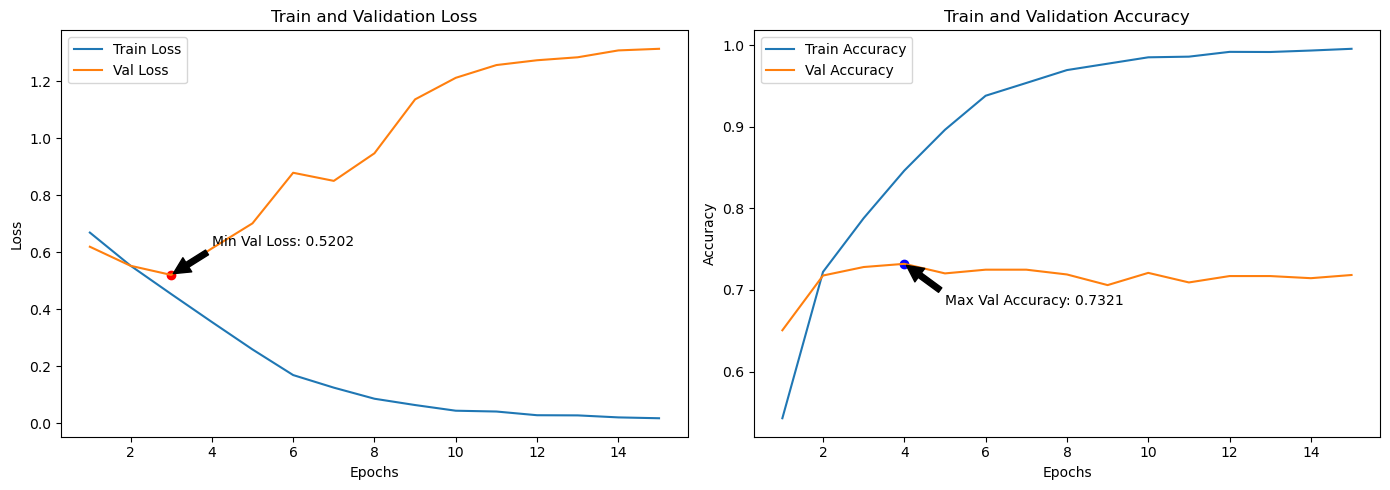

In [12]:
import matplotlib.pyplot as plt

# Given data
epochs = list(range(1, 16))
train_losses = [0.6687154758255929, 0.5527181051826725, 0.4532782048142205, 0.35534397972514853, 0.2590184402652085,
                0.169212618098148, 0.12508696045309384, 0.08622869447208359, 0.06410210725516663, 0.044225313491854955,
                0.041380021933036915, 0.02842603838416835, 0.027839794768624415, 0.020797551502255374, 0.017802997687643558]
val_losses = [0.6190763389070829, 0.5523151016483704, 0.5202338052913547, 0.6131090143074592, 0.7010652121777335,
              0.8783933240920305, 0.849924641661346, 0.9466816896262268, 1.1357009392231703, 1.2112354701384902,
              1.2559412320454915, 1.272808567310373, 1.283227643929422, 1.3073116516073544, 1.3129278759782512]
train_accuracies = [0.5427127486142811, 0.7222041082491033, 0.7880665145092924, 0.8464297358982719, 0.8964786436256929,
                    0.9382132376915553, 0.9538637104662536, 0.9696772089990219, 0.977502445386371, 0.9853276817737202,
                    0.9861428105640692, 0.992011737854581, 0.9918487120965113, 0.9936419954352788, 0.9957613302901859]
val_accuracies = [0.6505867014341591, 0.7177314211212517, 0.728161668839635, 0.7320730117340286, 0.7203389830508474,
                  0.7249022164276402, 0.7249022164276402, 0.7190352020860495, 0.7059973924380704, 0.7209908735332464,
                  0.7092568448500651, 0.7170795306388527, 0.7170795306388527, 0.7144719687092568, 0.7183833116036505]

# Plotting
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.scatter(epochs[val_losses.index(min(val_losses))], min(val_losses), color='red')  # Min Val Loss
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(f'Min Val Loss: {min(val_losses):.4f}', xy=(epochs[val_losses.index(min(val_losses))], min(val_losses)),
             xytext=(epochs[val_losses.index(min(val_losses))] + 1, min(val_losses) + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.scatter(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies), color='blue')  # Max Val Accuracy
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate(f'Max Val Accuracy: {max(val_accuracies):.4f}', xy=(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies)),
             xytext=(epochs[val_accuracies.index(max(val_accuracies))] + 1, max(val_accuracies) - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()


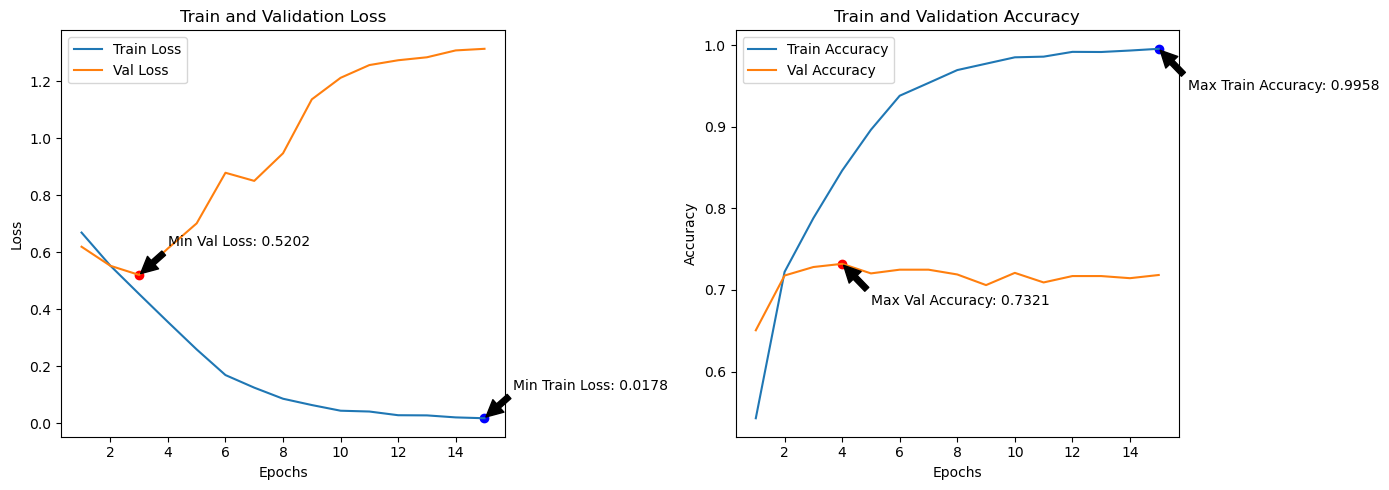

In [13]:
import matplotlib.pyplot as plt

# Given data
epochs = list(range(1, 16))
train_losses = [0.6687154758255929, 0.5527181051826725, 0.4532782048142205, 0.35534397972514853, 0.2590184402652085,
                0.169212618098148, 0.12508696045309384, 0.08622869447208359, 0.06410210725516663, 0.044225313491854955,
                0.041380021933036915, 0.02842603838416835, 0.027839794768624415, 0.020797551502255374, 0.017802997687643558]
val_losses = [0.6190763389070829, 0.5523151016483704, 0.5202338052913547, 0.6131090143074592, 0.7010652121777335,
              0.8783933240920305, 0.849924641661346, 0.9466816896262268, 1.1357009392231703, 1.2112354701384902,
              1.2559412320454915, 1.272808567310373, 1.283227643929422, 1.3073116516073544, 1.3129278759782512]
train_accuracies = [0.5427127486142811, 0.7222041082491033, 0.7880665145092924, 0.8464297358982719, 0.8964786436256929,
                    0.9382132376915553, 0.9538637104662536, 0.9696772089990219, 0.977502445386371, 0.9853276817737202,
                    0.9861428105640692, 0.992011737854581, 0.9918487120965113, 0.9936419954352788, 0.9957613302901859]
val_accuracies = [0.6505867014341591, 0.7177314211212517, 0.728161668839635, 0.7320730117340286, 0.7203389830508474,
                  0.7249022164276402, 0.7249022164276402, 0.7190352020860495, 0.7059973924380704, 0.7209908735332464,
                  0.7092568448500651, 0.7170795306388527, 0.7170795306388527, 0.7144719687092568, 0.7183833116036505]

# Plotting
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.scatter(epochs[val_losses.index(min(val_losses))], min(val_losses), color='red')  # Min Val Loss
plt.scatter(epochs[train_losses.index(min(train_losses))], min(train_losses), color='blue')  # Min Train Loss
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(f'Min Val Loss: {min(val_losses):.4f}', xy=(epochs[val_losses.index(min(val_losses))], min(val_losses)),
             xytext=(epochs[val_losses.index(min(val_losses))] + 1, min(val_losses) + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Min Train Loss: {min(train_losses):.4f}', xy=(epochs[train_losses.index(min(train_losses))], min(train_losses)),
             xytext=(epochs[train_losses.index(min(train_losses))] + 1, min(train_losses) + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.scatter(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies), color='red')  # Max Val Accuracy
plt.scatter(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies), color='blue')  # Max Train Accuracy
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate(f'Max Val Accuracy: {max(val_accuracies):.4f}', xy=(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies)),
             xytext=(epochs[val_accuracies.index(max(val_accuracies))] + 1, max(val_accuracies) - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Max Train Accuracy: {max(train_accuracies):.4f}', xy=(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies)),
             xytext=(epochs[train_accuracies.index(max(train_accuracies))] + 1, max(train_accuracies) - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()


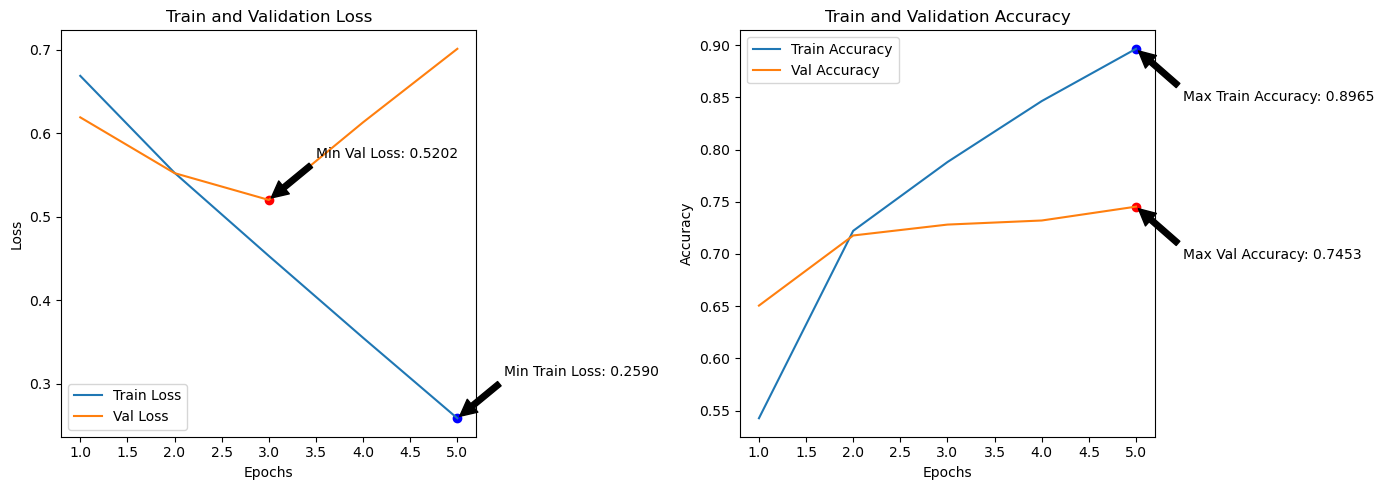

In [2]:
import matplotlib.pyplot as plt

# Given data up to epoch 5
epochs = list(range(1, 6))
train_losses = [0.6687154758255929, 0.5527181051826725, 0.4532782048142205, 0.35534397972514853, 0.2590184402652085]
val_losses = [0.6190763389070829, 0.5523151016483704, 0.5202338052913547, 0.6131090143074592, 0.7010652121777335]
train_accuracies = [0.5427127486142811, 0.7222041082491033, 0.7880665145092924, 0.8464297358982719, 0.8964786436256929]
val_accuracies = [0.6505867014341591, 0.7177314211212517, 0.728161668839635, 0.7320730117340286, 0.7453389830508474]

# Plotting
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.scatter(epochs[val_losses.index(min(val_losses))], min(val_losses), color='red')  # Min Val Loss
plt.scatter(epochs[train_losses.index(min(train_losses))], min(train_losses), color='blue')  # Min Train Loss
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(f'Min Val Loss: {min(val_losses):.4f}', xy=(epochs[val_losses.index(min(val_losses))], min(val_losses)),
             xytext=(epochs[val_losses.index(min(val_losses))] + 0.5, min(val_losses) + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Min Train Loss: {min(train_losses):.4f}', xy=(epochs[train_losses.index(min(train_losses))], min(train_losses)),
             xytext=(epochs[train_losses.index(min(train_losses))] + 0.5, min(train_losses) + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.scatter(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies), color='red')  # Max Val Accuracy
plt.scatter(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies), color='blue')  # Max Train Accuracy
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate(f'Max Val Accuracy: {max(val_accuracies):.4f}', xy=(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies)),
             xytext=(epochs[val_accuracies.index(max(val_accuracies))] + 0.5, max(val_accuracies) - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Max Train Accuracy: {max(train_accuracies):.4f}', xy=(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies)),
             xytext=(epochs[train_accuracies.index(max(train_accuracies))] + 0.5, max(train_accuracies) - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()
